In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sqlite3
%matplotlib inline
from IPython.core.display import HTML
pd.options.display.max_columns = 50
import seaborn as sb
import datetime
from sqlalchemy import create_engine
import psycopg2
HTML("<style>.container { width:100% !important; }</style>")

In [2]:
#sql_conn_local = sqlite3.connect('flask_app/data/analysed_data.sql')
#sql_cursor_local = sql_conn.cursor()
conn = psycopg2.connect("dbname='grb_2016_03' host='forespellpostgis.cusejoju89w7.eu-west-1.rds.amazonaws.com' user='kasper' password='VosseM08'")
cur = conn.cursor()
engine_AWS = create_engine('postgresql://%s:%s@forespellpostgis.cusejoju89w7.eu-west-1.rds.amazonaws.com:5432/grb_2016_03' %('kasper', 'VosseM08'))

In [4]:
engine = create_engine('postgresql://%s:%s@forespellpostgis.cusejoju89w7.eu-west-1.rds.amazonaws.com:5432/grb_2016_03' %('namabayi_dev', 'namabayi_dev_40'))
conn = psycopg2.connect("dbname='grb_2016_03' host='forespellpostgis.cusejoju89w7.eu-west-1.rds.amazonaws.com' user='namabayi_dev' password='namabayi_dev_40'")
cur = conn.cursor()

In [20]:
#name_info = pd.read_sql('''SELECT * FROM voornamen_pivot WHERE region = 'Vlaanderen' AND sex = 'M'  LIMIT 10''', con=engine)
name_info = pd.read_sql('''SELECT name, minus18 FROM voornamen_pivot WHERE region = 'Vlaanderen' AND sex = 'M' ''', con=engine)

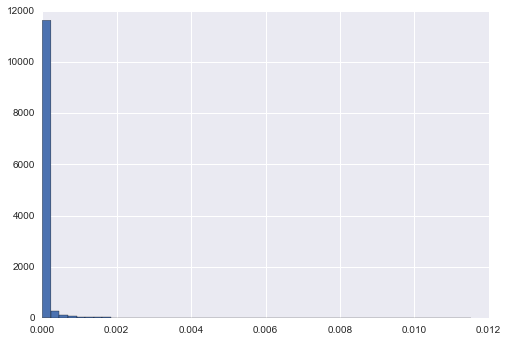

In [29]:
name_info['prior'] = name_info['minus18'] / np.sum(name_info['minus18'])
name_info['prior'].hist(bins=50)
#name_info.loc[name_info['name'] == 'Victor','minus18'] / np.sum(name_info['minus18'])

In [50]:
odds = pd.read_csv('flask_app/odds.csv')
odds['odds_ratio_2'] = odds['odds_ratio'] * odds['minus18'] / np.sum(odds['minus18'])
odds = odds.sort_values('odds_ratio', ascending=False)
print(odds['name'].head(20))
odds = odds.sort_values('odds_ratio_2', ascending=False)
print(odds['name'].head(20))

452      Blanche
154    Marjolein
993      Hayriye
601      Mafalda
153        Karla
353       Albina
184      Aurélie
87         Luise
846     Stefanie
907     Gertrude
700     Gilberta
890       Sheila
263       Sylvie
276       Denise
777       Bertha
923    Gerardine
358    Hubertina
788       Joanna
287    Gabrielle
718      Ariette
Name: name, dtype: object
490         Sarah
184       Aurélie
846      Stefanie
710       Justine
154     Marjolein
179         Ilona
908          Elif
510      Angelina
228         Aïcha
788        Joanna
263        Sylvie
321        Robine
96        Karlien
287     Gabrielle
448       Margaux
487          Elsa
353        Albina
48          Irina
182    Frédérique
276        Denise
Name: name, dtype: object


In [72]:
pd.read_sql('''SELECT * FROM sessions''', con=engine_AWS).tail(5)

,ip_address,session_ID,time,user_ID,user_agent,window_height,window_width
333,127.0.0.1,ttCDD+WANqAHGuhwlRURWYX+mvEz0Afk,2016-09-18 17:08:05.412191,3gG4j0QstaS/DoYZfBTQMlCOfcoo7/0G,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; ...,766,1440
334,127.0.0.1,ia4CIb19ASzCJW2m70yhuVgy/8vejcpN,2016-09-18 17:08:50.166670,gyIivrZNDOiis8mhj7J9nSHeSbeRIEOa,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_3...,150,1280
335,127.0.0.1,b5cDg8b2SPAe5tLhyxMNCUeQwA3436qK,2016-09-18 17:10:03.835002,gyIivrZNDOiis8mhj7J9nSHeSbeRIEOa,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_3...,391,1280
336,127.0.0.1,E0IcScWf0sQqcglXrMGgMAF6J2XhrYCT,2016-09-18 17:11:02.722404,gyIivrZNDOiis8mhj7J9nSHeSbeRIEOa,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_3...,391,1280
337,127.0.0.1,JwLm6IqN9rP5P+T73l8dpX0fyJtYrF9v,2016-09-18 17:12:35.963271,gyIivrZNDOiis8mhj7J9nSHeSbeRIEOa,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_3...,391,1280


In [55]:
feedback = pd.read_sql('''SELECT * FROM feedback''', con=engine_AWS)
feedback.columns = [column.lower() for column in feedback.columns]
feedback.to_sql(con=engine_AWS, name='feedback',index=False, if_exists='replace')

In [68]:
pd.read_sql('''SELECT * FROM feedback''', con=engine_AWS).tail()

,feedback,name,session_id,time,user_id,sex
439,like,Emile,hMErCykJ4PQyxpKyKcVJZJEajQC5oJWt,2016-09-05 11:50:11.941045,wbwCqGiw9/OnompOE6L6vCpIC93t53+U,M
440,no_like,Richard,hMErCykJ4PQyxpKyKcVJZJEajQC5oJWt,2016-09-05 11:50:19.174217,wbwCqGiw9/OnompOE6L6vCpIC93t53+U,M
441,no_like,Sasha,hMErCykJ4PQyxpKyKcVJZJEajQC5oJWt,2016-09-05 11:50:54.944717,wbwCqGiw9/OnompOE6L6vCpIC93t53+U,M
442,no_like,Diego,hMErCykJ4PQyxpKyKcVJZJEajQC5oJWt,2016-09-05 11:51:12.248166,wbwCqGiw9/OnompOE6L6vCpIC93t53+U,M
443,no_like,Alexis,hMErCykJ4PQyxpKyKcVJZJEajQC5oJWt,2016-09-05 11:51:18.306556,wbwCqGiw9/OnompOE6L6vCpIC93t53+U,M


In [67]:
engine_AWS.execute('''DELETE FROM feedback WHERE time ='F' ''')